# Putting everthing to work
In this example, I make use of the previous routines and apply basic machine learning tasks to a real dataset.

Topics:
1. Manipulating data with Pandas.
2. Vectorization with sklearn.
3. Important features with forests of trees.
4. Classification with sklearn.
5. Precision scores with sklearn.
6. Polynomial and linear regression.


In [1]:
#This routine to plot learning curve is from sklearn documentation.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Adult dataset
Now we work on the Adult UCL dataset.
This is a popular dataset with the following data about a collection of adults:

# Header

age: continuous.

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, ithout-pay, Never-worked.

fnlwgt: continuous.

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

sex: Female, Male.

capital-gain: continuous.

capital-loss: continuous.

hours-per-week: continuous.

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

class: >50K, <=50K

In [2]:
#Import data from files
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/adult/adult.data', header=None).head(2000)



df.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation",
              "relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","class"]
#nfeature=len(df.columns)
#print("Number of features: "+str(nfeature-1))
#nfeature=14
df.head(5)

df.shape





(2000, 15)

Here we start using concepts of machine learning.
1. We split the dataset into train and test sets.
2. Non numeric features are vectorized.

In [3]:
from sklearn_pandas import DataFrameMapper, cross_val_score
import pandas as pd
import numpy as np
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer

#Target column
# select 'class' column. If <=50K set to 1 and > 50K to 0
df['class'] = df['class'].str.strip()
y = df.loc[:,'class']
y = np.where(y == '<=50K' , 0, 1)


#Split dataframe into train and test datasets (partition = 80 and 20%):
msk = np.random.rand(len(df)) < 0.8
y_train = y[msk]
y_test  = y[~msk]

print("Training set with %d entries\n" % (y_train.size))
print("Test set with %d entries\n" % (y_test.size))

mapper_df = DataFrameMapper([
    (['age'], sklearn.preprocessing.StandardScaler()),
    ('workclass', sklearn.preprocessing.LabelBinarizer()),
    (['fnlwgt'],sklearn.preprocessing.StandardScaler()),
    ('education',sklearn.preprocessing.LabelBinarizer()),
    ('marital-status',sklearn.preprocessing.LabelBinarizer()),
    ('occupation',sklearn.preprocessing.LabelBinarizer()),
    ('native-country',sklearn.preprocessing.LabelBinarizer()),
    ('native-country',sklearn.preprocessing.LabelBinarizer()),
    ('sex',sklearn.preprocessing.LabelBinarizer()),
    (['hours-per-week'], sklearn.preprocessing.StandardScaler()),
], df_out=True)


#
df_vectorized=np.round(mapper_df.fit_transform(df.copy()), 2)
df_vectorized.head()

features=df_vectorized.columns

#Convert to np.matrix again:
X=df_vectorized.as_matrix()


Training set with 1583 entries

Test set with 417 entries



/Users/rangel/Virtualenvs/pip3-venv/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


# Find Important features with forests of tress:
See previous example 
<a href="https://github.com/trangel/Data-Science/blob/master/plot_forest_importances.ipynb"> ipynb </a>
or read sklearn documentation.

Feature ranking:
1. feature 0 (                 age): 0.156637
2. feature 9 (              fnlwgt): 0.142756
3. feature 123 (      hours-per-week): 0.097736
4. feature 28 (marital-status_ Married-civ-spouse): 0.096689
5. feature 30 (marital-status_ Never-married): 0.057758
6. feature 37 (occupation_ Exec-managerial): 0.034580


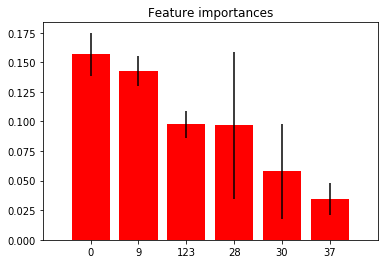

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Retain only few features
nfeatures=6

# Print the feature ranking (top ten only)
print("Feature ranking:")

for f in range(nfeatures): 
    print("%d. feature %d (%20s): %f" % 
          (f + 1, indices[f],features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
#print(X.shape[1])
plt.bar(range(nfeatures), importances[indices[:nfeatures]],
       color="r", yerr=std[indices[:nfeatures]], align="center")
plt.xticks(range(nfeatures), indices[:nfeatures])
plt.xlim([-1, nfeatures])
plt.show()


We find that most features are not correlated with the class:
Lets make a logistic regression using the top ten features above:

# Plot learning curves
Use training and cross validation datasets.

In [5]:
#Routine to plot learning curve from sklearn
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import svm, datasets



def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


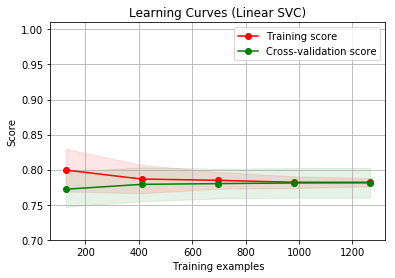

In [6]:
from sklearn import svm
#Use the feature ranking to reduce the dimensionality of the dataset:

indx_list=(np.array(indices[:nfeatures],dtype=np.int))

X=df_vectorized.iloc[:,indx_list]
X_train=X[msk]
X_test=X[~msk]


title = "Learning Curves (Linear SVC)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = svm.LinearSVC(C=1.0)
plot_learning_curve(estimator, title, X_train, y_train, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()




# Precision score

Use sklearn to plot the precision score.
This time, I use the test dataset.

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
The best value is 1 and the worst value is 0.


In [7]:
from sklearn.metrics import classification_report

estimator.fit(X_train, y_train) 

y_pred = estimator.predict(X_test)

ntest=y_pred.size


#Total of true positives:
from sklearn.metrics import precision_score

#Precision score for test dataset:
print("Precision score for test dataset: \n")
precision_score(y_test, y_pred, average='micro')  




Precision score for test dataset: 



0.78896882494004794

# Polynomial Regression

Let's try to improve the model with a polynomial regression of degree 2.
This step can take some time, be patient.

In [8]:
# Import
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly=poly.fit_transform(X_test)




In [9]:
#from sklearn.linear_model import LinearRegression
#estimator = LinearRegression()

#title = "Learning Curves (Linear SVC)"
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = svm.LinearSVC(C=1.0)
#plot_learning_curve(estimator, title, X_train_poly, y_train, (0.7, 1.01), cv=cv, n_jobs=4)

#plt.show()





In [10]:
#estimator = svm.LinearSVC(C=1.0)
estimator.fit(X_train_poly, y_train)
y_pred = estimator.predict(X_test_poly)

#Precision score for test dataset:
print("Precision score for test dataset: \n")
precision_score(y_test, y_pred, average='micro')  

Precision score for test dataset: 



0.80815347721822539